Buisness objective:

    Build a forecast model to predict the furniture sales of a certain store.

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
import statsmodels.api as sm    # for LJung-box 

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing Dataset
df = pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xls',parse_dates=['Order Date','Ship Date'])
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Data Understanding

In [3]:
# day wise data present

In [4]:
#shape
df.shape

(9994, 21)

In [5]:
# checking statistical values
df.describe([0.25,0.75,0.90,0.95])

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
90%,8994.700000,94122.000000,572.706000,7.000000,0.400000,89.281620
95%,9494.350000,98006.000000,956.984245,8.000000,0.700000,168.470400
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [6]:
#if any special char present in the dataset.replacing special char to nan
df=df.replace(to_replace=[" ?","?","!","@","/"],value=np.nan)

In [7]:
#checking null values
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

* There is no null values present in the data

In [8]:
# datatypes of the columns
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

* We can see both dates are in datetime formet so,we dont need to convert it datetime formet.
* So, many object columns present.

## EDA

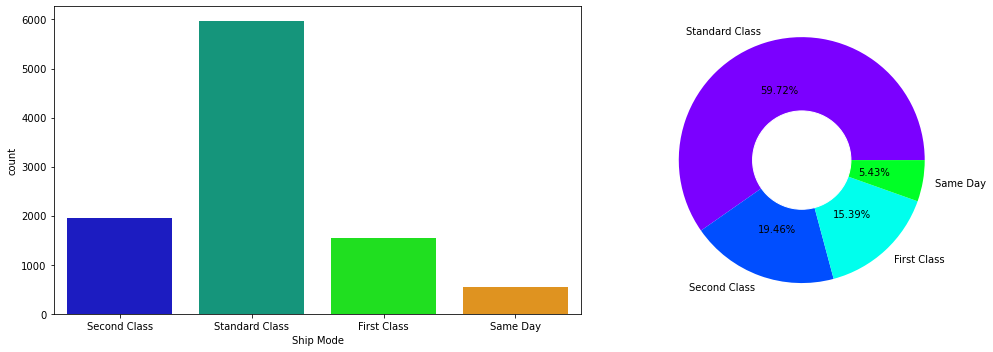

In [9]:
# Univariate analysis

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(df['Ship Mode'],palette='nipy_spectral')

plt.subplot(122)
d = df['Ship Mode'].value_counts()
label=['Standard Class','Second Class','First Class','Same Day']
palette_color = sns.color_palette('gist_rainbow_r')
plt.pie(d, labels=label, autopct='%.2f%%',colors=palette_color)
cir = plt.Circle((0,0),0.4,color='white')
ax=plt.gcf()
ax.gca().add_artist(cir)




plt.tight_layout()
plt.show()

* Around 60% orders are shipped by standard class.
* 6% orders are derivered same day.

In [10]:
numeric_feat = [col for col in df.columns if df[col].dtypes=='int64'or df[col].dtypes=='float64']
numeric_feat.remove('Row ID')

In [11]:
numeric_feat

['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']

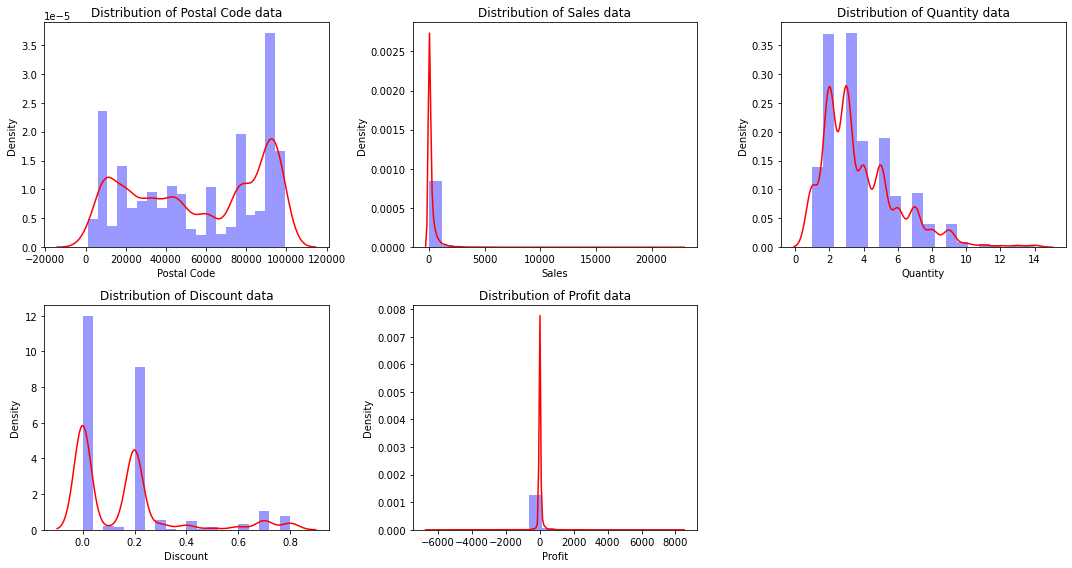

In [12]:
plt.figure(figsize=(15,8))
for i,col in enumerate(numeric_feat,1):
    plt.subplot(2,3,i)
    plt.title(f"Distribution of {col} data")
    sns.distplot(df[col],kde=True,kde_kws={'color':'r'},hist_kws={'color':'b'},bins=20)
    plt.tight_layout()
    plt.plot()

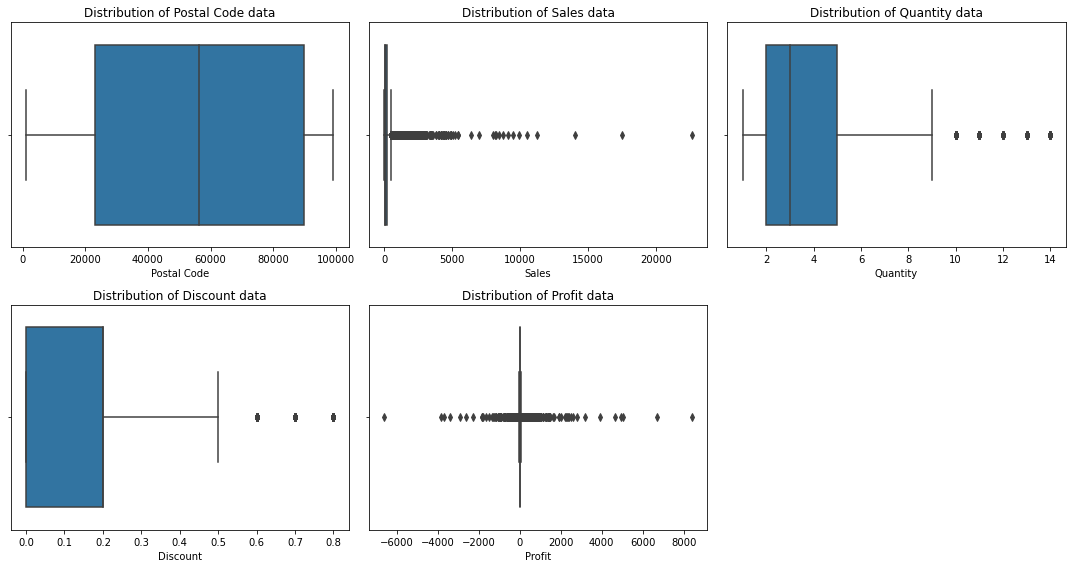

In [13]:
plt.figure(figsize=(15,8))
for i,col in enumerate(numeric_feat,1):
    plt.subplot(2,3,i)
    plt.title(f"Distribution of {col} data")
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.plot

* Sales and profit columns containing more outliers  
* Quantity and Discount columns showing right skewness.

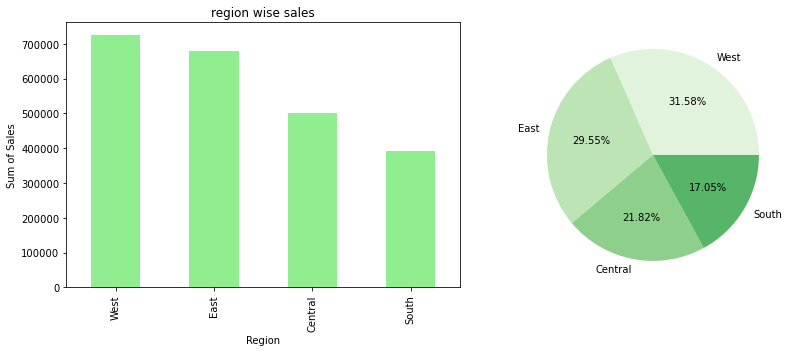

In [14]:
# region wise sales

plt.figure(figsize=(12,5))
plt.subplot(121)
df.groupby(by="Region")['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color='lightgreen',ylabel='Sum of Sales')
plt.title('region wise sales')

plt.subplot(122)
palette_color = sns.color_palette('Greens')
label=['West','East','Central','South']
plt.pie(df.groupby(by="Region")['Sales'].sum().sort_values(ascending=False),labels=label,autopct='%.2f%%',colors=palette_color)

plt.tight_layout()
plt.show()

* West region contributing more to sales which around 32%.
* for sales least contributing region is south which around 18%

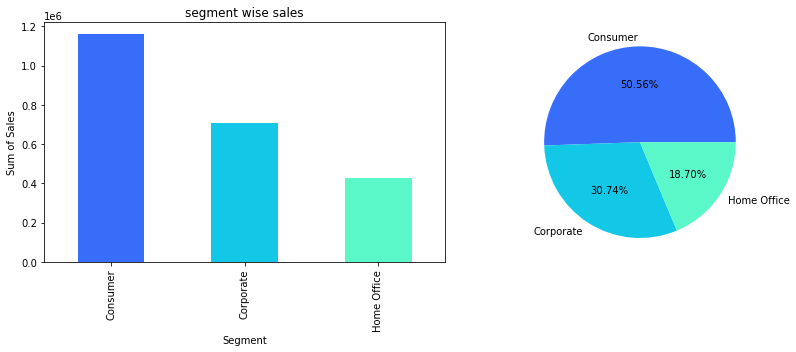

In [15]:
#segment wise sales.

plt.figure(figsize=(12,5))
plt.subplot(121)
palette_color = sns.color_palette('rainbow')
df.groupby(by="Segment")['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color=palette_color,ylabel='Sum of Sales')
plt.title("segment wise sales")

plt.subplot(122)
palette_color = sns.color_palette('rainbow')
label=['Consumer', 'Corporate', 'Home Office']
plt.pie(df.groupby(by="Segment")['Sales'].sum().sort_values(ascending=False),labels=label,autopct='%.2f%%',colors=palette_color)

plt.tight_layout()
plt.show()

* Consumer segment contributing more to Sales which around 51%
* For Sales least contributing segment is Home office.

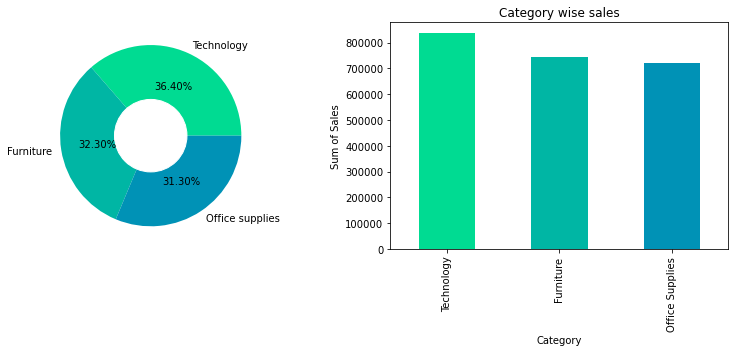

In [16]:
#catgory wise sales..

plt.figure(figsize=(11,5))
plt.subplot(122)
palette_color = sns.color_palette('winter_r')
df.groupby(by="Category")['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color=palette_color,ylabel='Sum of Sales')
plt.title("Category wise sales")

plt.subplot(121)
palette_color = sns.color_palette('winter_r')
label=['Technology', 'Furniture', 'Office supplies']
plt.pie(df.groupby(by="Category")['Sales'].sum().sort_values(ascending=False),
        labels=label,autopct='%.2f%%',colors=palette_color)
cir = plt.Circle((0,0),0.4,color='white')
ax=plt.gcf()
ax.gca().add_artist(cir)

plt.tight_layout()
plt.show()

* Technology category sales was high among other categories.

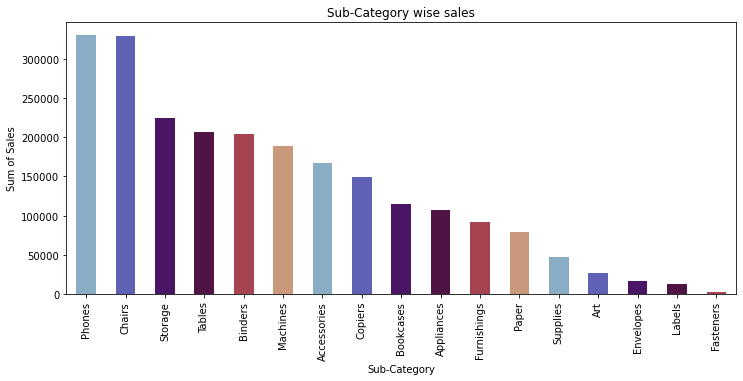

In [17]:
palette_color=sns.color_palette('twilight')
df.groupby(by="Sub-Category")['Sales'].sum().sort_values(ascending=False).plot(kind='bar',
                                                                               figsize=(12,5),
                                                                               color=palette_color,
                                                                               ylabel='Sum of Sales',
                                                                               title='Sub-Category wise sales')
plt.show()

* phones and chairs are contributing more to sales.
* least contributing sub category is fasteners.

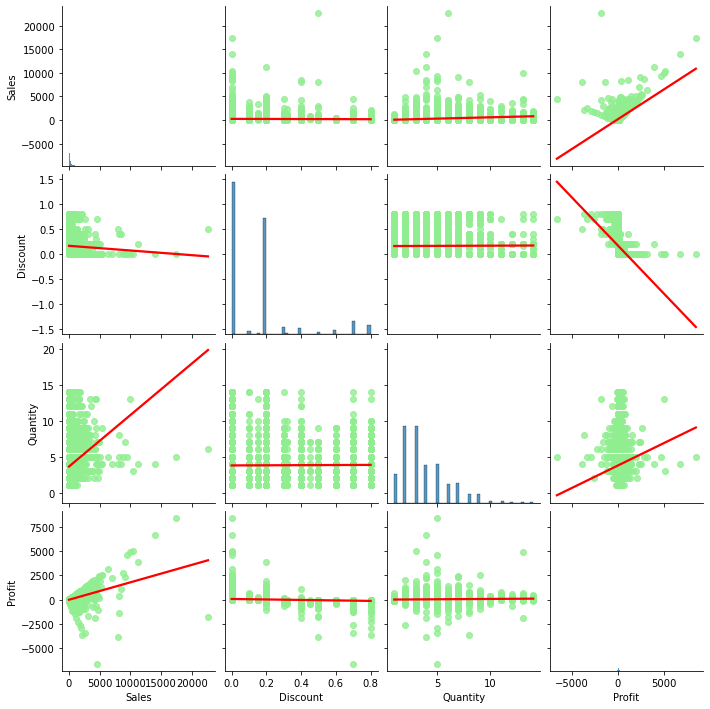

In [18]:
pairs=df[['Sales','Discount','Quantity','Profit']]
sns.pairplot(pairs,kind='reg',plot_kws={'ci':None,'color':'red','scatter_kws':{'color':'lightgreen'}})
plt.show()

* we can see profit and quantiy showing slightly postive correlation
* sales and profit also showing slightly positive correlation


## Data preprocessing

In [19]:
#seperating sales and order data for forcasting sales..
d = df[['Order Date','Sales']]

# for time series model data should be sequential and for that..
d = d.sort_values(by='Order Date',ascending=True)

d.head(20)

,Order Date,Sales
7980,2014-01-03,16.448
739,2014-01-04,11.784
740,2014-01-04,272.736
741,2014-01-04,3.540
1759,2014-01-05,19.536
7476,2014-01-06,5.480
7474,2014-01-06,2573.820
7475,2014-01-06,609.980
7180,2014-01-06,12.780
7477,2014-01-06,391.980


In [20]:
#setting index as date
d.set_index('Order Date',inplace=True)
d.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,11.784
2014-01-04,272.736
2014-01-04,3.540
2014-01-05,19.536


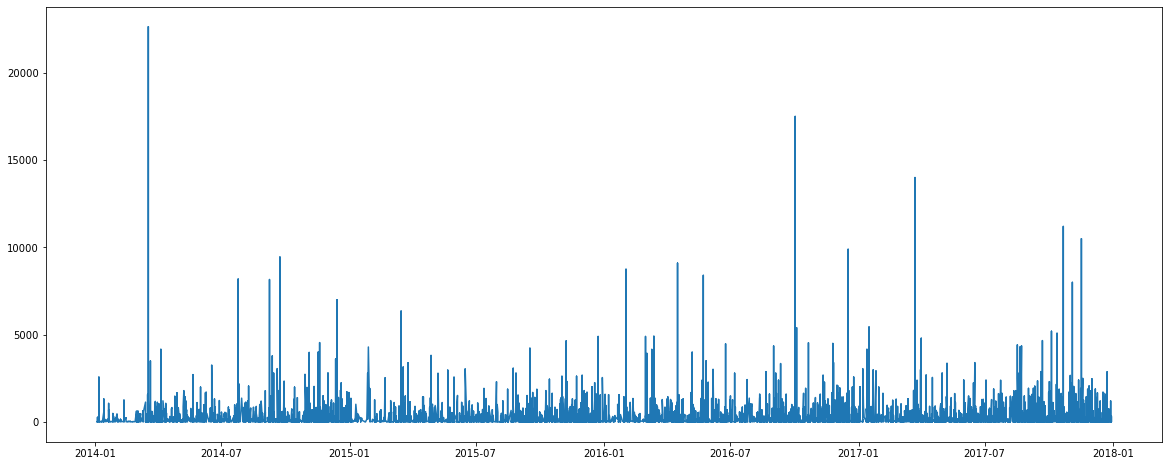

In [21]:
plt.figure(figsize=(20,8))
plt.plot(d)

* Day wise data more spreaded and difficult to intrepret

In [22]:
#since its a day wise data,resampled to weekly data..
data = d.resample('W').mean()
data

,Sales
Order Date,
2014-01-05,64.808800
2014-01-12,287.473250
2014-01-19,204.960318
2014-01-26,132.496138
2014-02-02,149.300909
...,...
2017-12-03,248.881308
2017-12-10,183.259221
2017-12-17,136.311208


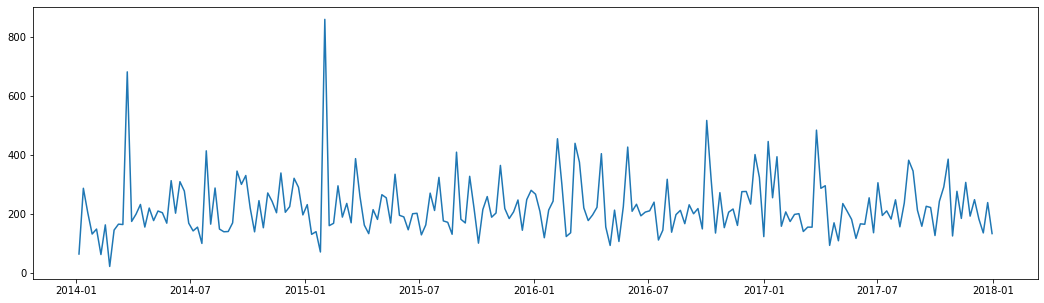

In [23]:
plt.figure(figsize=(18,5))
plt.plot(data['Sales'])
plt.show()

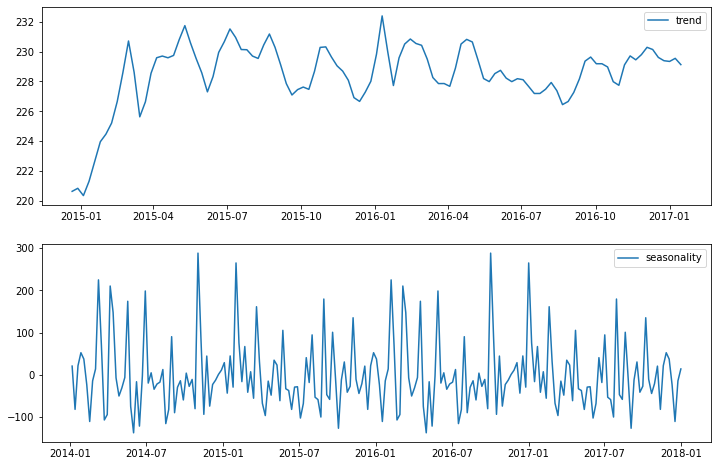

In [24]:
#time series components to find seasonality or trend present in the data
decomposed = seasonal_decompose(data['Sales'],period=100)

seasonality = decomposed.seasonal
trend = decomposed.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* There is an overall increasing trend in the data along with some seasonal variations.

### Smoothening

In [25]:
# since our data having trend and seasonality.so,triple exponential smoothening
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
beta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
gamma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

a = []
b = []
g = []
mean_absolute_deviation = []
mean_absolute_percentage_error = []

for i in alpha:
    for j in beta:
        for k in gamma:
            smoothen = ExponentialSmoothing(data['Sales'],trend='additive',seasonal='additive',seasonal_periods=10).fit(smoothing_level=i,
                                                                                                 smoothing_trend=j,
                                                                                                 smoothing_seasonal=k)
            data_set1 = smoothen.fittedvalues
            
            #mean absolute deivation
            error2 = data['Sales']-data_set1
            abs_error2 = abs(error2)
            mad2 = np.mean(abs_error2)
            mean_absolute_deviation.append(mad2)
            a.append(i)
            b.append(j)
            g.append(k)
            
            #mean absolute percentage error
            ape_error2 = np.round((abs_error2/data['Sales'])*100,2)
            mape2 = np.mean(ape_error2)
            mean_absolute_percentage_error.append(mape2)


In [26]:
er = pd.DataFrame({'Alpha':a,"Beta":b,"Gamma":g,"mean_absolute_deviation":mean_absolute_deviation,
                   'mean_absolute_percentage_error':mean_absolute_percentage_error})

In [27]:
er.sort_values(by='mean_absolute_percentage_error',ascending=True)

,Alpha,Beta,Gamma,mean_absolute_deviation,mean_absolute_percentage_error
0,0.1,0.1,0.1,7.434568e+01,3.895541e+01
2,0.1,0.1,0.3,7.697112e+01,3.895651e+01
1,0.1,0.1,0.2,7.596813e+01,3.897411e+01
3,0.1,0.1,0.4,7.866014e+01,3.940608e+01
101,0.2,0.1,0.2,7.834168e+01,3.951904e+01
...,...,...,...,...,...
988,1.0,0.9,0.9,1.188224e+12,5.640980e+11
998,1.0,1.0,0.9,6.712228e+12,3.367021e+12
979,1.0,0.8,1.0,2.738146e+13,1.368841e+13
989,1.0,0.9,1.0,7.400870e+13,3.698400e+13


* By this dataframe we can see all combinations of alpha, beta and gamma.we can choose low error value.
* The low error value of alpha beta and gamma  (0.1,0.1,0.1)

In [28]:
#smoothening by low error alpha beta and gamma value
alpha=0.1; beta=0.1; gamma=0.1
smooth = ExponentialSmoothing(data,trend='additive',seasonal='additive',seasonal_periods=10).fit(smoothing_level=alpha,
                                                                                                 smoothing_trend=beta,
                                                                                                 smoothing_seasonal=gamma)
data_set = smooth.fittedvalues

#mean absolute deivation
error2 = data['Sales']-data_set
abs_error2 = abs(error2)
mad2 = np.mean(abs_error2)
print("mean absolute deivation: ",round(mad2,2))

#mean absolute percentage error
ape_error2 = np.round((abs_error2/data['Sales'])*100,2)

mape2 = np.mean(ape_error2)
print("mean absolute percentage error: ",round(mape2,2),"%")

mean absolute deivation:  74.35
mean absolute percentage error:  38.96 %


In [29]:
data_set

Order Date
2014-01-05    138.200344
2014-01-12    204.653317
2014-01-19    161.111738
2014-01-26    187.976878
2014-02-02    183.940055
                 ...    
2017-12-03    267.594666
2017-12-10    205.014073
2017-12-17    255.107848
2017-12-24    216.722807
2017-12-31    250.509478
Freq: W-SUN, Length: 209, dtype: float64

## Stationarity

In [30]:
# for pacf and acf data must be stationary,so we need to check stationarity
# function for stationarity
def check_stationarity(data):
    pvalue = adfuller(data)[1]
    if pvalue < 0.05:
        ret ='data is stationary.proceed to modeling'
    else:
        ret ='data is not stationary.make it stationary'
    return(ret)

In [31]:
#stationarity check
check_stationarity(data_set)

'data is stationary.proceed to modeling'

* Our data is stationary.so no need to do differencing.

### ACF and PACF plots

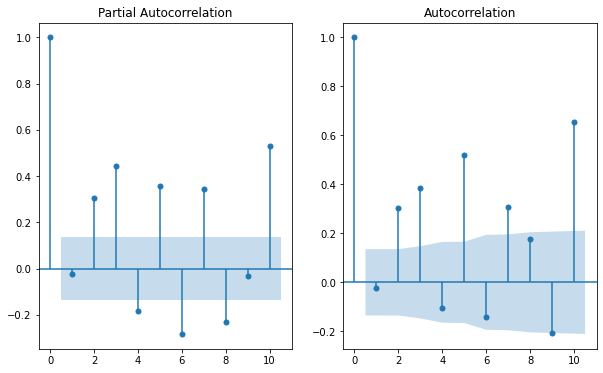

In [32]:
fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(data_set,lags=10,ax=ax[0])
plot_acf(data_set,lags=10,ax=ax[1])      #default Confidence level is 95%

plt.show()

* By PACF and ACF plots p and q values are(7,6)

In [33]:
#splitting the data into train and test
rows = int(len(data)*0.80)         #  Ratio
train = data_set[:rows]
test = data_set[rows:]
print("shape of train and test dataset: ",train.shape,test.shape)

shape of train and test dataset:  (167,) (42,)


## ARMA MODEL

In [34]:
#taking (p,q) as (2,2)
#since data is stationary so arima model becomes arma
p = np.arange(7)
q = np.arange(6)

p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
MAPE = []
count=0

for i in p:
    for j in q:
        try:
            models.append(ARIMA(train,order=(i,0,j)).fit())
            p_val.append(i)
            q_val.append(j)
        except:
            pass

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train),end=len(train)+len(test)-1)
    mod.append('model'+str(count))
    mse.append(mean_squared_error(test,pred))
    rmse.append(np.sqrt(mean_squared_error(test,pred)))
    count = count+1
    #MAPE
    MAPE.append(np.mean(abs((test - pred)/test)*100))
    
    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')
k = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,'MAPE':MAPE,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})

In [35]:
#finding low RMSE model
k.sort_values(by='RMSE',ascending=True)[:10]

,model,p,q,MSE,RMSE,MAPE,AIC,BIC,Ljung
36,model36,6,3,813.392570,28.520038,10.811413,1617.695056,1651.992988,model is good
37,model37,6,4,849.609198,29.148056,11.069318,1617.693197,1655.109123,model is good
38,model38,6,5,944.857608,30.738536,11.996692,1586.136141,1626.670060,model is good
19,model19,3,2,1034.174290,32.158580,12.399891,1678.117788,1699.943745,model is good
15,model15,2,4,1127.027957,33.571237,13.215051,1652.492733,1677.436683,model is good
35,model35,6,2,1134.064309,33.675871,13.218823,1614.353956,1645.533895,model is good
27,model27,4,5,1148.334882,33.887090,13.841108,1625.043174,1659.341106,model is good
24,model24,4,2,1149.684787,33.907002,13.057799,1648.407672,1673.351623,model is good
16,model16,2,5,1151.187170,33.929149,13.071885,1656.933607,1684.995552,model is not good
31,model31,5,3,1176.934606,34.306481,13.693533,1615.837680,1647.017618,model is good


* We can choose (p,q) as (6,3) based on the low Rmse value.

In [36]:
# Building ARMA model with (p,q) as (6,3)
p=6; d=0; q=3
model1 = ARIMA(train,order=(p,d,q)).fit()

In [37]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  167
Model:                     ARMA(6, 3)   Log Likelihood                -797.848
Method:                       css-mle   S.D. of innovations             27.556
Date:                Mon, 08 Aug 2022   AIC                           1617.695
Time:                        08:51:55   BIC                           1651.993
Sample:                    01-05-2014   HQIC                          1631.616
                         - 03-12-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.2483      1.390    164.937      0.000     226.524     231.973
ar.L1.y       -0.1107      0.065     -1.691      0.091      -0.239       0.018
ar.L2.y        0.6446      0.066      9.758      0.000       0.515       0.774
ar.L3.y        1.0214      0.083     12.297      0.000       0.859       1.184
ar.L4.y       -0.0493      0.082     -0.598      0.550      -0.211       0.112
ar.L5.y       -0.0801      0.068     -1.184      0.236      -0.213       0.052
ar.L6.y       -0.5277      0.067     -7.872      0.000      -0.659      -0.396
ma.L1.y        0.5169      0.012     41.643      0.000       0.493       0.541
ma.L2.y       -0.5169      0.027    -19.307      0.000      -0.569      -0.464
ma.L3.y       -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8092           -0.5917j            1.0025           -0.3995
AR.2           -0.8092           +0.5917j            1.0025            0.3995
AR.3            1.0521           -0.1154j            1.0584           -0.0174
AR.4            1.0521           +0.1154j            1.0584            0.0174
AR.5           -0.3187           -1.2576j            1.2974           -0.2895
AR.6           -0.3187           +1.2576j            1.2974            0.2895
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.7585           -0.6517j            1.0000           -0.3870
MA.3           -0.7585           +0.6517j            1.0000            0.3870
-----------------------------------------------------------------------------
"""

### Forecast--ARMA Model

In [38]:
forcast_arma=model1.predict(start=len(train), end=len(train)+len(test)-1)

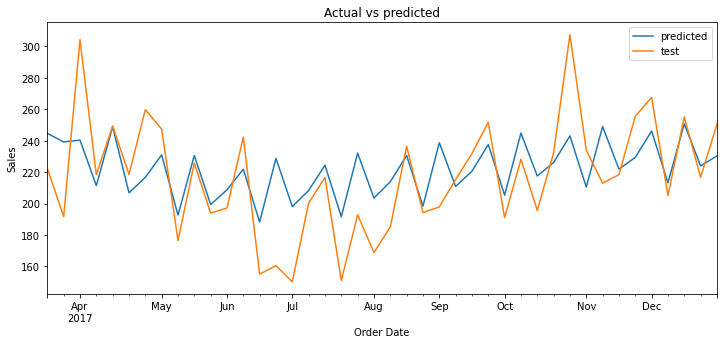

In [39]:
plt.figure(figsize=(12,5))
forcast_arma.plot(label='predicted')
test.plot(label='test')
plt.title('Actual vs predicted')
plt.ylabel('Sales')
plt.legend()
plt.show()

* We can see test means actual data and predicted data similary matching.

In [40]:
#calculating mse,rmse
mse1 = mean_squared_error(test,forcast_arma)
print("ARMA model 1. p={},q={} \n\tmse = {} \n\trmse = {}".format(p,q,mse1,np.sqrt(mse1)))

SARIMAX model 1. p=6,q=3 
	mse = 813.3925701117931 
	rmse = 28.520038045412793


### Future forecast

In [41]:
future_forcast_arma = model1.predict(start=len(train), end=len(train)+len(test)+12)

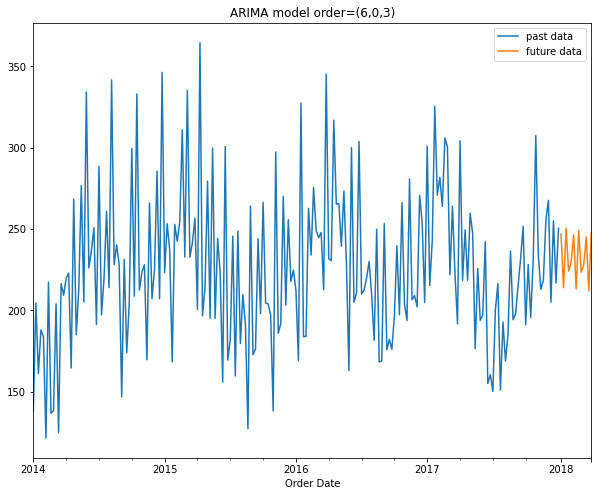

In [42]:
data_set.plot(figsize=(10,8),label='past data')
future_forcast_arma[42:].plot(label='future data')
plt.title('ARIMA model order=(6,0,3)')
plt.legend()
plt.show()

* ARIMA Model predicted future sales will be volatile.

## SARIMA Model

In [43]:
p = np.arange(7)
q = np.arange(6)

p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
MAPE=[]
count=0

for i in p:
    for j in q:
        try:
            models.append(SARIMAX(train,order=(i,0,j),seasonal_order=(i,0,j,10)).fit())
            p_val.append(i)
            q_val.append(j)
        except:
            pass

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train),end=len(train)+len(test)-1)
    mod.append('model'+str(count))
    mse.append(mean_squared_error(test,pred))
    rmse.append(np.sqrt(mean_squared_error(test,pred)))
    count = count+1
    #MAPE
    MAPE.append(np.mean(abs((test - pred)/test)*100))
    
    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')
s = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,'MAPE':MAPE,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})

In [44]:
s.sort_values(by='RMSE',ascending=True)

,model,p,q,MSE,RMSE,MAPE,AIC,BIC,Ljung
15,model15,2,4,761.391125,27.593317,9.981032,1572.607278,1613.141197,model is good
21,model21,3,5,1166.085608,34.147996,13.696609,1568.494607,1621.500501,model is good
22,model22,4,0,1186.294168,34.442621,13.969660,1562.500299,1590.562243,model is good
17,model17,3,0,1213.590833,34.836631,14.128540,1558.818787,1580.644743,model is good
30,model30,5,2,1218.970369,34.913756,14.415210,1569.923601,1616.693508,model is good
11,model11,2,0,1301.271351,36.073139,14.285721,1560.850091,1576.440060,model is good
29,model29,5,1,1302.249582,36.086695,14.778431,1568.964059,1609.497978,model is good
6,model6,1,1,1316.079740,36.277813,14.704571,1554.637001,1570.226970,model is good
20,model20,3,4,1350.287136,36.746253,15.346607,1564.807874,1611.577781,model is good
27,model27,4,5,1385.841275,37.226889,15.866946,1571.457257,1630.699140,model is good


In [45]:
#building sarima model with p,q as 2,4
p=2; d=0; q=4 
model2 = SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,10)).fit()

In [46]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  167
Model:             SARIMAX(2, 0, 4)x(2, 0, 4, 10)   Log Likelihood                -773.304
Date:                            Mon, 08 Aug 2022   AIC                           1572.607
Time:                                    08:59:25   BIC                           1613.141
Sample:                                01-05-2014   HQIC                          1589.059
                                     - 03-12-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8953      0.046     40.935      0.000       1.805       1.986
ar.L2         -0.9196      0.048    -19.278      0.000      -1.013      -0.826
ma.L1         -1.4078      0.087    -16.124      0.000      -1.579      -1.237
ma.L2          0.2810      0.117      2.408      0.016       0.052       0.510
ma.L3          0.0905      0.136      0.664      0.507      -0.177       0.358
ma.L4          0.1880      0.087      2.160      0.031       0.017       0.359
ar.S.L10       1.9355      0.531      3.642      0.000       0.894       2.977
ar.S.L20      -0.9388      0.504     -1.864      0.062      -1.926       0.048
ma.S.L10      -1.4123      0.622     -2.271      0.023      -2.631      -0.194
ma.S.L20       0.4794      0.271      1.772      0.076      -0.051       1.010
ma.S.L30       0.1063      0.170      0.624      0.532      -0.227       0.440
ma.S.L40      -0.1422      0.195     -0.730      0.465      -0.524       0.240
sigma2       491.9007     66.809      7.363      0.000     360.957     622.844
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                35.10
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.11
Prob(H) (two-sided):                  0.61   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forcasting and model evalution--SARIMA model

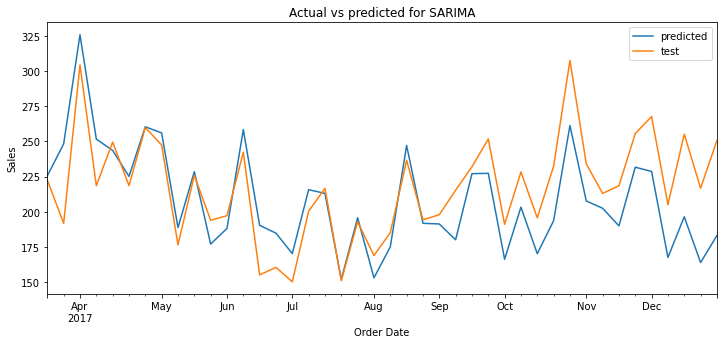

In [47]:
forcast_sarima=model2.predict(start=len(train), end=len(train)+len(test)-1)
plt.figure(figsize=(12,5))
forcast_sarima.plot(label='predicted')
test.plot(label='test')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [48]:
#calculating mse,rmse
mse2 = mean_squared_error(test,forcast_sarima)
print("SARIMA model 1. p={},q={} \n\tmse = {} \n\trmse = {}".format(p,q,mse2,np.sqrt(mse2)))

SARIMAX model 1. p=2,q=4 
	mse = 761.3911248912501 
	rmse = 27.59331667073116


# Future forecasting

In [49]:
future_forcast_sarima = model2.predict(start=len(train), end=len(train)+len(test)+12)

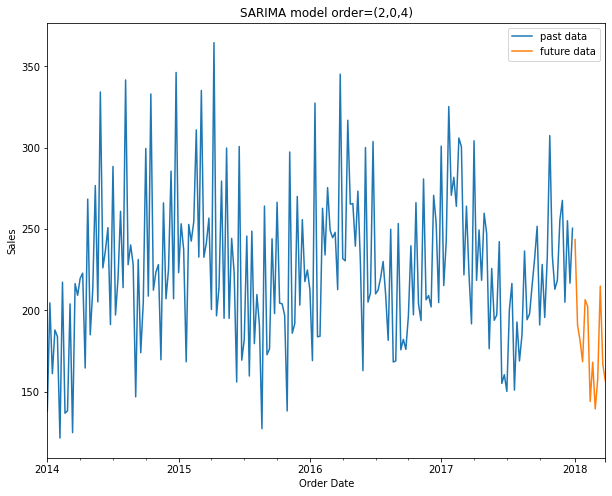

In [50]:
data_set.plot(figsize=(10,8),label='past data')
future_forcast_sarima[42:].plot(label='future data')
plt.title('SARIMA model order=(2,0,4)')
plt.ylabel('Sales')
plt.legend()
plt.show()

* SARIMA model predicted future Sales will be down.

## SARIMAX MODEL

In [51]:
df = df.sort_values(by='Order Date',ascending=True)

In [52]:
# exogeneous columns for predict
frame = df[['Order Date','Sales','Quantity','Discount','Profit']]
frame = frame.set_index('Order Date')

In [53]:
#conveting daily data to weekly data
frame = frame.resample("W").mean()

In [54]:
frame

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-05,64.808800,2.600000,0.320000,-11.110980
2014-01-12,287.473250,3.062500,0.112500,82.671462
2014-01-19,204.960318,4.500000,0.229545,18.131195
2014-01-26,132.496138,3.724138,0.034483,26.139231
2014-02-02,149.300909,3.000000,0.131818,21.776973
...,...,...,...,...
2017-12-03,248.881308,4.338462,0.169231,16.013970
2017-12-10,183.259221,3.664122,0.115267,8.390592
2017-12-17,136.311208,3.467532,0.133117,9.856660


In [55]:
#splitting the data into train and test

rows = int(len(frame)*0.80)
train_set =frame.iloc[:rows,:]
test_set = frame.iloc[rows:,:]
print('train and test shape',train_set.shape,test_set.shape)

train and test shape (167, 4) (42, 4)


In [56]:
exog_train = train_set[['Quantity', 'Discount', 'Profit']]
exog_test = test_set[['Quantity', 'Discount', 'Profit']]

In [57]:

p = np.arange(7)
q = np.arange(6)

p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
        try:
            models.append(SARIMAX(train_set['Sales'],order=(i,0,j),seasonal_order=(i,0,j,10),exog=exog_train.values).fit())
            p_val.append(i)
            q_val.append(j)
        except:
            pass

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=0,end=len(test_set['Sales'])-1,exog=exog_test.values)
    mod.append('model'+str(count))
    mse.append(mean_squared_error(test_set['Sales'],pred))
    rmse.append(np.sqrt(mean_squared_error(test_set['Sales'],pred)))
    count = count+1

    
    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')
s = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})

In [58]:
s.sort_values(by='RMSE',ascending=True)

,model,p,q,MSE,RMSE,AIC,BIC,Ljung
14,model14,2,3,7210.173130,84.912738,2014.124500,2057.776414,model is good
0,model0,0,1,7237.349816,85.072615,2008.250774,2026.958737,model is good
5,model5,1,0,7259.183181,85.200840,2008.272435,2026.980398,model is good
11,model11,2,0,7387.502593,85.950582,2009.012172,2033.956123,model is good
17,model17,3,0,7399.721325,86.021633,2011.060436,2042.240374,model is good
1,model1,0,2,7468.196065,86.418725,2008.476530,2033.420480,model is good
2,model2,0,3,7472.957815,86.446271,2010.629375,2041.809313,model is good
22,model22,3,5,7516.008333,86.694915,2015.020560,2077.380436,model is good
12,model12,2,1,7546.204379,86.868892,2010.382931,2041.562869,model is good
7,model7,1,2,7574.305560,87.030486,2010.405506,2041.585444,model is good


In [59]:
#building sarimax model with p,q as 2,3
p=2; d=0; q=3
model3 = SARIMAX(train_set['Sales'],order=(p,0,q),seasonal_order=(p,0,q,10),exog=exog_train.values).fit()

In [60]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  167
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 10)   Log Likelihood                -993.062
Date:                            Mon, 08 Aug 2022   AIC                           2014.125
Time:                                    09:07:14   BIC                           2057.776
Sample:                                01-05-2014   HQIC                          2031.842
                                     - 03-12-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            59.7179      9.372      6.372      0.000      41.349      78.087
x2           -60.2670    187.228     -0.322      0.748    -427.227     306.693
x3             0.5018      0.197      2.546      0.011       0.115       0.888
ar.L1          1.1254      0.082     13.645      0.000       0.964       1.287
ar.L2         -0.9516      0.066    -14.476      0.000      -1.080      -0.823
ma.L1         -1.2068      0.162     -7.430      0.000      -1.525      -0.888
ma.L2          0.9717      0.202      4.799      0.000       0.575       1.369
ma.L3         -0.0505      0.153     -0.331      0.741      -0.350       0.249
ar.S.L10       1.0460     17.326      0.060      0.952     -32.913      35.005
ar.S.L20      -0.2185     14.117     -0.015      0.988     -27.888      27.451
ma.S.L10      -0.8621     17.317     -0.050      0.960     -34.803      33.079
ma.S.L20       0.0660     10.896      0.006      0.995     -21.289      21.421
ma.S.L30       0.0376      1.889      0.020      0.984      -3.666       3.741
sigma2      9677.0544   1066.183      9.076      0.000    7587.373    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1223.43
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             2.51
Prob(H) (two-sided):                  0.54   Kurtosis:                        15.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* By this summary sales is highly dependent on discount

## Forcasting and Evaluation SARIMAX:

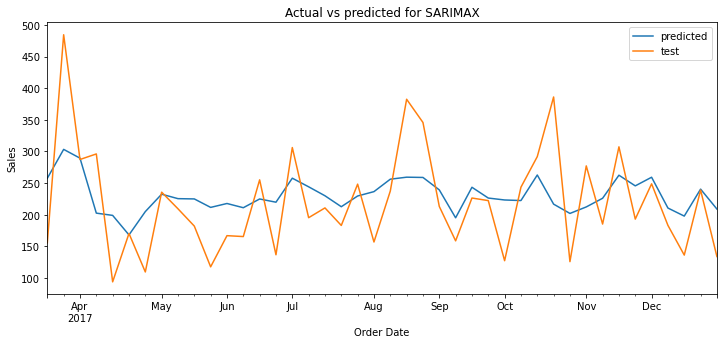

In [61]:
forcast_sarimax=model3.predict(start=len(train_set), end=len(train_set)+len(test_set)-1,exog=exog_test.values)
plt.figure(figsize=(12,5))
forcast_sarimax.plot(label='predicted')
test_set['Sales'].plot(label='test')
plt.title('Actual vs predicted for SARIMAX')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [62]:
#calculating mse,rmse
mse3 = mean_squared_error(test_set['Sales'],forcast_sarimax)
print("SARIMAX model 1. p={},q={} \n\tmse = {} \n\trmse = {}".format(p,q,mse3,np.sqrt(mse3)))

SARIMAX model 1. p=2,q=3 
	mse = 4745.519591185313 
	rmse = 68.88773179010406


## comparison:

In [63]:
print("ARIMA MODEL RMSE:{} |  SARIMA MODEL RMSE:{} | SARIMAX MODEL RMSE:{}".format(np.sqrt(mse1),np.sqrt(mse2),np.sqrt(mse3)))

ARIMA MODEL RMSE:28.520038045412793 |  SARIMA MODEL RMSE:27.59331667073116 | SARIMAX MODEL RMSE:68.88773179010406


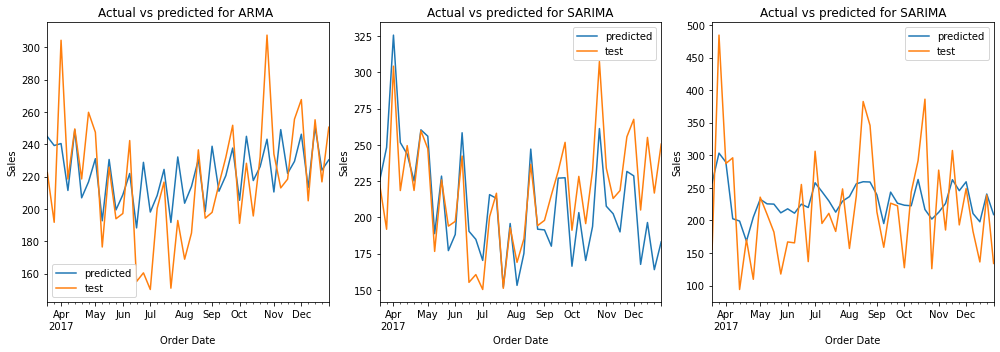

In [65]:
plt.figure(figsize=(14,5))
plt.subplot(131)
forcast_arma.plot(label='predicted')
test.plot(label='test')
plt.title('Actual vs predicted for ARMA ')
plt.ylabel('Sales')
plt.legend()


plt.subplot(132)
forcast_sarima.plot(label='predicted')
test.plot(label='test')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('Sales')
plt.legend()

plt.subplot(133)
forcast_sarimax.plot(label='predicted')
test_set['Sales'].plot(label='test')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('Sales')
plt.legend()

plt.tight_layout()
plt.show()


* By this three models actual vs predicted plots we can see SARIMA model actual and predicted are similalry matching.
* SARIMA model RMSE also less compared to other models.

Future predictions:

    * future sales are predicted to 12 weeks.
    * ARMA Model indicates sales will be volatile for 12 weeks.
    * SARIMA model predicted sales will be slightly down for 12 weeks. 
    